In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from typing import Union

In [2]:
def sliding_chunks_matmul_qk(q: torch.Tensor, k: torch.Tensor, w: int, padding_value: float):
    '''Matrix multiplicatio of query x key tensors using with a sliding window attention pattern.
    This implementation splits the input into overlapping chunks of size 2w (e.g. 512 for pretrained Longformer)
    with an overlap of size w'''
    bsz, seqlen, num_heads, head_dim = q.size()
    assert seqlen % (w * 2) == 0
    assert q.size() == k.size()

    chunks_count = seqlen // w - 1

    # group bsz and num_heads dimensions into one, then chunk seqlen into chunks of size w * 2
    q = q.transpose(1, 2).reshape(bsz * num_heads, seqlen, head_dim)
    k = k.transpose(1, 2).reshape(bsz * num_heads, seqlen, head_dim)

    chunk_q = _chunk(q, w)
    chunk_k = _chunk(k, w)

    # matrix multipication
    # bcxd: bsz*num_heads x chunks x 2w x head_dim
    # bcyd: bsz*num_heads x chunks x 2w x head_dim
    # bcxy: bsz*num_heads x chunks x 2w x 2w
    chunk_attn = torch.einsum('bcxd,bcyd->bcxy', (chunk_q, chunk_k))  # multiply

    # convert diagonals into columns
    diagonal_chunk_attn = _skew(chunk_attn, direction=(0, 0, 0, 1), padding_value=padding_value)

    # allocate space for the overall attention matrix where the chunks are compined. The last dimension
    # has (w * 2 + 1) columns. The first (w) columns are the w lower triangles (attention from a word to
    # w previous words). The following column is attention score from each word to itself, then
    # followed by w columns for the upper triangle.

    diagonal_attn = diagonal_chunk_attn.new_empty((bsz * num_heads, chunks_count + 1, w, w * 2 + 1))

    # copy parts from diagonal_chunk_attn into the compined matrix of attentions
    # - copying the main diagonal and the upper triangle
    diagonal_attn[:, :-1, :, w:] = diagonal_chunk_attn[:, :, :w, :w + 1]
    diagonal_attn[:, -1, :, w:] = diagonal_chunk_attn[:, -1, w:, :w + 1]
    # - copying the lower triangle
    diagonal_attn[:, 1:, :, :w] = diagonal_chunk_attn[:, :, - (w + 1):-1, w + 1:]
    diagonal_attn[:, 0, 1:w, 1:w] = diagonal_chunk_attn[:, 0, :w - 1, 1 - w:]

    # separate bsz and num_heads dimensions again
    diagonal_attn = diagonal_attn.view(bsz, num_heads, seqlen, 2 * w + 1).transpose(2, 1)

    mask_invalid_locations(diagonal_attn, w, 1, False)
    return diagonal_attn

def _chunk(x, w):
    '''convert into overlapping chunkings. Chunk size = 2w, overlap size = w'''

    # non-overlapping chunks of size = 2w
    x = x.view(x.size(0), x.size(1) // (w * 2), w * 2, x.size(2))

    # use `as_strided` to make the chunks overlap with an overlap size = w
    chunk_size = list(x.size())
    chunk_size[1] = chunk_size[1] * 2 - 1

    chunk_stride = list(x.stride())
    chunk_stride[1] = chunk_stride[1] // 2
    return x.as_strided(size=chunk_size, stride=chunk_stride)

def _skew(x, direction, padding_value):
    '''Convert diagonals into columns (or columns into diagonals depending on `direction`'''
    x_padded = F.pad(x, direction, value=padding_value)
    x_padded = x_padded.view(*x_padded.size()[:-2], x_padded.size(-1), x_padded.size(-2))
    return x_padded

def mask_invalid_locations(input_tensor: torch.Tensor, w: int, d: Union[torch.Tensor, int], autoregressive: bool) -> torch.Tensor:
    affected_seq_len, beginning_mask, ending_mask = _get_invalid_locations_mask(w, d, autoregressive, input_tensor.device)
    seq_len = input_tensor.size(1)
    beginning_input = input_tensor[:, :affected_seq_len, :, :w+1]
    beginning_mask = beginning_mask[:, :seq_len].expand(beginning_input.size())
    beginning_input.masked_fill_(beginning_mask, -float('inf'))
    if not autoregressive:
        ending_input = input_tensor[:, -affected_seq_len:, :, -(w+1):]
        ending_mask = ending_mask[:, -seq_len:].expand(ending_input.size())
        ending_input.masked_fill_(ending_mask, -float('inf'))
        
def _get_invalid_locations_mask(w: int, d: Union[torch.Tensor,int], autoregressive: bool, device: str):
    if isinstance(d, int):
        affected_seq_len = w * d
        mask = _get_invalid_locations_mask_fixed_dilation(affected_seq_len, w, d)
        mask = mask[None, :, None, :]
    else:
        affected_seq_len = w * d.max()
        head_masks = []
        d_list = d.cpu().numpy().tolist()
        for d in d_list:
            one_head_mask = _get_invalid_locations_mask_fixed_dilation(affected_seq_len, w, d)
            head_masks.append(one_head_mask)
        mask = torch.stack(head_masks, dim=-2)
        mask = mask[None, :, :, :]

    ending_mask = None if autoregressive else mask.flip(dims=(1, 3)).bool().to(device)
    return affected_seq_len, mask.bool().to(device), ending_mask

def sliding_chunks_matmul_pv(prob: torch.Tensor, v: torch.Tensor, w: int):
    '''Same as sliding_chunks_matmul_qk but for prob and value tensors. It is expecting the same output
    format from sliding_chunks_matmul_qk'''
    bsz, seqlen, num_heads, head_dim = v.size()
    assert seqlen % (w * 2) == 0
    assert prob.size()[:3] == v.size()[:3]
    assert prob.size(3) == 2 * w + 1
    chunks_count = seqlen // w - 1
    # group bsz and num_heads dimensions into one, then chunk seqlen into chunks of size 2w
    chunk_prob = prob.transpose(1, 2).reshape(bsz * num_heads, seqlen // w, w, 2 * w + 1)

    # group bsz and num_heads dimensions into one
    v = v.transpose(1, 2).reshape(bsz * num_heads, seqlen, head_dim)

    # pad seqlen with w at the beginning of the sequence and another w at the end
    padded_v = F.pad(v, (0, 0, w, w), value=-1)

    # chunk padded_v into chunks of size 3w and an overlap of size w
    chunk_v_size = (bsz * num_heads, chunks_count + 1, 3 * w, head_dim)
    chunk_v_stride = padded_v.stride()
    chunk_v_stride = chunk_v_stride[0], w * chunk_v_stride[1], chunk_v_stride[1], chunk_v_stride[2]
    chunk_v = padded_v.as_strided(size=chunk_v_size, stride=chunk_v_stride)

    skewed_prob = _skew2(chunk_prob, padding_value=0)

    context = torch.einsum('bcwd,bcdh->bcwh', (skewed_prob, chunk_v))
    return context.view(bsz, num_heads, seqlen, head_dim).transpose(1, 2)

def _skew2(x, padding_value):
    '''shift every row 1 step to right converting columns into diagonals'''
    # X = B x C x M x L
    B, C, M, L = x.size()
    x = F.pad(x, (0, M + 1), value=padding_value)  # B x C x M x (L+M+1)
    x = x.view(B, C, -1)  # B x C x ML+MM+M
    x = x[:, :, :-M]  # B x C x ML+MM
    x = x.view(B, C, M, M + L)  # B x C, M x L+M
    x = x[:, :, :, :-1]
    return x

def _get_invalid_locations_mask_fixed_dilation(seq_len: int, w: int, d: int):
    diagonals_list = []
    for j in range(-d * w, d, d):
        diagonal_mask = torch.zeros(seq_len, device='cpu', dtype=torch.uint8)
        diagonal_mask[:-j] = 1
        diagonals_list.append(diagonal_mask)
    return torch.stack(diagonals_list, dim=-1)

In [3]:
class LongformerSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, 
                 layer_id, attention_mode='sliding_chunks', autoregressive=False,
                 attention_window=[5] * 2, attention_dilation=[1] * 2):
        super(LongformerSelfAttention, self).__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))
        self.num_heads = num_attention_heads
        self.head_dim = int(hidden_size / num_attention_heads)
        self.embed_dim = hidden_size

        self.query = nn.Linear(hidden_size, self.embed_dim)
        self.key = nn.Linear(hidden_size, self.embed_dim)
        self.value = nn.Linear(hidden_size, self.embed_dim)

        self.query_global = nn.Linear(hidden_size, self.embed_dim)
        self.key_global = nn.Linear(hidden_size, self.embed_dim)
        self.value_global = nn.Linear(hidden_size, self.embed_dim)

        self.dropout = attention_probs_dropout_prob

        self.layer_id = layer_id
        self.attention_window = attention_window[self.layer_id]
        self.attention_dilation = attention_dilation[self.layer_id]
        self.attention_mode = attention_mode
        self.autoregressive = autoregressive
        assert self.attention_window > 0
        assert self.attention_dilation > 0
        assert self.attention_mode in ['tvm', 'sliding_chunks', 'sliding_chunks_no_overlap']
        if self.attention_mode in ['sliding_chunks', 'sliding_chunks_no_overlap']:
            assert not self.autoregressive  # not supported
            assert self.attention_dilation == 1  # dilation is not supported

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        output_attentions=False,
    ):
        '''
        The `attention_mask` is changed in `BertModel.forward` from 0, 1, 2 to
            -ve: no attention
              0: local attention
            +ve: global attention
        '''
        assert encoder_hidden_states is None, "`encoder_hidden_states` is not supported and should be None"
        assert encoder_attention_mask is None, "`encoder_attention_mask` is not supported and shiould be None"

        if attention_mask is not None:
            attention_mask = attention_mask.squeeze(dim=2).squeeze(dim=1)
            key_padding_mask = attention_mask < 0
            extra_attention_mask = attention_mask > 0
            remove_from_windowed_attention_mask = attention_mask != 0

            num_extra_indices_per_batch = extra_attention_mask.long().sum(dim=1)
            max_num_extra_indices_per_batch = num_extra_indices_per_batch.max()
            if max_num_extra_indices_per_batch <= 0:
                extra_attention_mask = None
            else:
                # To support the case of variable number of global attention in the rows of a batch,
                # we use the following three selection masks to select global attention embeddings
                # in a 3d tensor and pad it to `max_num_extra_indices_per_batch`
                # 1) selecting embeddings that correspond to global attention
                extra_attention_mask_nonzeros = extra_attention_mask.nonzero(as_tuple=True)
                zero_to_max_range = torch.arange(0, max_num_extra_indices_per_batch,
                                                 device=num_extra_indices_per_batch.device)
                # mask indicating which values are actually going to be padding
                selection_padding_mask = zero_to_max_range < num_extra_indices_per_batch.unsqueeze(dim=-1)
                # 2) location of the non-padding values in the selected global attention
                selection_padding_mask_nonzeros = selection_padding_mask.nonzero(as_tuple=True)
                # 3) location of the padding values in the selected global attention
                selection_padding_mask_zeros = (selection_padding_mask == 0).nonzero(as_tuple=True)
        else:
            remove_from_windowed_attention_mask = None
            extra_attention_mask = None
            key_padding_mask = None

        hidden_states = hidden_states.transpose(0, 1)
        seq_len, bsz, embed_dim = hidden_states.size()
        assert embed_dim == self.embed_dim
        q = self.query(hidden_states)
        k = self.key(hidden_states)
        v = self.value(hidden_states)
        q /= math.sqrt(self.head_dim)

        q = q.view(seq_len, bsz, self.num_heads, self.head_dim).transpose(0, 1)
        k = k.view(seq_len, bsz, self.num_heads, self.head_dim).transpose(0, 1)
        # attn_weights = (bsz, seq_len, num_heads, window*2+1)
        if self.attention_mode == 'tvm':
            q = q.float().contiguous()
            k = k.float().contiguous()
            attn_weights = diagonaled_mm_tvm(q, k, self.attention_window, self.attention_dilation, False, 0, False)
        elif self.attention_mode == "sliding_chunks":
            attn_weights = sliding_chunks_matmul_qk(q, k, self.attention_window, padding_value=0)
        elif self.attention_mode == "sliding_chunks_no_overlap":
            attn_weights = sliding_chunks_no_overlap_matmul_qk(q, k, self.attention_window, padding_value=0)
        else:
            raise False
        mask_invalid_locations(attn_weights, self.attention_window, self.attention_dilation, False)
        if remove_from_windowed_attention_mask is not None:
            # This implementation is fast and takes very little memory because num_heads x hidden_size = 1
            # from (bsz x seq_len) to (bsz x seq_len x num_heads x hidden_size)
            remove_from_windowed_attention_mask = remove_from_windowed_attention_mask.unsqueeze(dim=-1).unsqueeze(dim=-1)
            # cast to float/half then replace 1's with -inf
            float_mask = remove_from_windowed_attention_mask.type_as(q).masked_fill(remove_from_windowed_attention_mask, -10000.0)
            repeat_size = 1 if isinstance(self.attention_dilation, int) else len(self.attention_dilation)
            float_mask = float_mask.repeat(1, 1, repeat_size, 1)
            ones = float_mask.new_ones(size=float_mask.size())  # tensor of ones
            # diagonal mask with zeros everywhere and -inf inplace of padding
            if self.attention_mode == 'tvm':
                d_mask = diagonaled_mm_tvm(ones, float_mask, self.attention_window, self.attention_dilation, False, 0, False)
            elif self.attention_mode == "sliding_chunks":
                d_mask = sliding_chunks_matmul_qk(ones, float_mask, self.attention_window, padding_value=0)
            elif self.attention_mode == "sliding_chunks_no_overlap":
                d_mask = sliding_chunks_no_overlap_matmul_qk(ones, float_mask, self.attention_window, padding_value=0)

            attn_weights += d_mask
        assert list(attn_weights.size())[:3] == [bsz, seq_len, self.num_heads]
        assert attn_weights.size(dim=3) in [self.attention_window * 2 + 1, self.attention_window * 3]

        # the extra attention
        if extra_attention_mask is not None:
            selected_k = k.new_zeros(bsz, max_num_extra_indices_per_batch, self.num_heads, self.head_dim)
            selected_k[selection_padding_mask_nonzeros] = k[extra_attention_mask_nonzeros]
            # (bsz, seq_len, num_heads, max_num_extra_indices_per_batch)
            selected_attn_weights = torch.einsum('blhd,bshd->blhs', (q, selected_k))
            selected_attn_weights[selection_padding_mask_zeros[0], :, :, selection_padding_mask_zeros[1]] = -10000
            # concat to attn_weights
            # (bsz, seq_len, num_heads, extra attention count + 2*window+1)
            attn_weights = torch.cat((selected_attn_weights, attn_weights), dim=-1)
        attn_weights_float = F.softmax(attn_weights, dim=-1, dtype=torch.float32)  # use fp32 for numerical stability
        if key_padding_mask is not None:
            # softmax sometimes inserts NaN if all positions are masked, replace them with 0
            attn_weights_float = torch.masked_fill(attn_weights_float, key_padding_mask.unsqueeze(-1).unsqueeze(-1), 0.0)
        attn_weights = attn_weights_float.type_as(attn_weights)
        attn_probs = F.dropout(attn_weights_float.type_as(attn_weights), p=self.dropout, training=self.training)
        v = v.view(seq_len, bsz, self.num_heads, self.head_dim).transpose(0, 1)
        attn = 0
        if extra_attention_mask is not None:
            selected_attn_probs = attn_probs.narrow(-1, 0, max_num_extra_indices_per_batch)
            selected_v = v.new_zeros(bsz, max_num_extra_indices_per_batch, self.num_heads, self.head_dim)
            selected_v[selection_padding_mask_nonzeros] = v[extra_attention_mask_nonzeros]
            # use `matmul` because `einsum` crashes sometimes with fp16
            # attn = torch.einsum('blhs,bshd->blhd', (selected_attn_probs, selected_v))
            attn = torch.matmul(selected_attn_probs.transpose(1, 2), selected_v.transpose(1, 2).type_as(selected_attn_probs)).transpose(1, 2)
            attn_probs = attn_probs.narrow(-1, max_num_extra_indices_per_batch, attn_probs.size(-1) - max_num_extra_indices_per_batch).contiguous()

        if self.attention_mode == 'tvm':
            v = v.float().contiguous()
            attn += diagonaled_mm_tvm(attn_probs, v, self.attention_window, self.attention_dilation, True, 0, False)
        elif self.attention_mode == "sliding_chunks":
            attn += sliding_chunks_matmul_pv(attn_probs, v, self.attention_window)
        elif self.attention_mode == "sliding_chunks_no_overlap":
            attn += sliding_chunks_no_overlap_matmul_pv(attn_probs, v, self.attention_window)
        else:
            raise False

        attn = attn.type_as(hidden_states)
        assert list(attn.size()) == [bsz, seq_len, self.num_heads, self.head_dim]
        attn = attn.transpose(0, 1).reshape(seq_len, bsz, embed_dim).contiguous()

        # For this case, we'll just recompute the attention for these indices
        # and overwrite the attn tensor. TODO: remove the redundant computation
        if extra_attention_mask is not None:
            selected_hidden_states = hidden_states.new_zeros(max_num_extra_indices_per_batch, bsz, embed_dim)
            selected_hidden_states[selection_padding_mask_nonzeros[::-1]] = hidden_states[extra_attention_mask_nonzeros[::-1]]

            q = self.query_global(selected_hidden_states)
            k = self.key_global(hidden_states)
            v = self.value_global(hidden_states)
            q /= math.sqrt(self.head_dim)

            q = q.contiguous().view(max_num_extra_indices_per_batch, bsz * self.num_heads, self.head_dim).transpose(0, 1)  # (bsz*self.num_heads, max_num_extra_indices_per_batch, head_dim)
            k = k.contiguous().view(-1, bsz * self.num_heads, self.head_dim).transpose(0, 1)  # bsz * self.num_heads, seq_len, head_dim)
            v = v.contiguous().view(-1, bsz * self.num_heads, self.head_dim).transpose(0, 1)  # bsz * self.num_heads, seq_len, head_dim)
            attn_weights = torch.bmm(q, k.transpose(1, 2))
            assert list(attn_weights.size()) == [bsz * self.num_heads, max_num_extra_indices_per_batch, seq_len]

            attn_weights = attn_weights.view(bsz, self.num_heads, max_num_extra_indices_per_batch, seq_len)
            attn_weights[selection_padding_mask_zeros[0], :, selection_padding_mask_zeros[1], :] = -10000.0
            if key_padding_mask is not None:
                attn_weights = attn_weights.masked_fill(
                    key_padding_mask.unsqueeze(1).unsqueeze(2),
                    -10000.0,
                )
            attn_weights = attn_weights.view(bsz * self.num_heads, max_num_extra_indices_per_batch, seq_len)
            attn_weights_float = F.softmax(attn_weights, dim=-1, dtype=torch.float32)  # use fp32 for numerical stability
            attn_probs = F.dropout(attn_weights_float.type_as(attn_weights), p=self.dropout, training=self.training)
            selected_attn = torch.bmm(attn_probs, v)
            assert list(selected_attn.size()) == [bsz * self.num_heads, max_num_extra_indices_per_batch, self.head_dim]

            selected_attn_4d = selected_attn.view(bsz, self.num_heads, max_num_extra_indices_per_batch, self.head_dim)
            nonzero_selected_attn = selected_attn_4d[selection_padding_mask_nonzeros[0], :, selection_padding_mask_nonzeros[1]]
            attn[extra_attention_mask_nonzeros[::-1]] = nonzero_selected_attn.view(len(selection_padding_mask_nonzeros[0]), -1).type_as(hidden_states)

        context_layer = attn.transpose(0, 1)
        if output_attentions:
            if extra_attention_mask is not None:
                # With global attention, return global attention probabilities only
                # batch_size x num_heads x max_num_global_attention_tokens x sequence_length
                # which is the attention weights from tokens with global attention to all tokens
                # It doesn't not return local attention
                # In case of variable number of global attantion in the rows of a batch,
                # attn_weights are padded with -10000.0 attention scores
                attn_weights = attn_weights.view(bsz, self.num_heads, max_num_extra_indices_per_batch, seq_len)
            else:
                # without global attention, return local attention probabilities
                # batch_size x num_heads x sequence_length x window_size
                # which is the attention weights of every token attending to its neighbours
                attn_weights = attn_weights.permute(0, 2, 1, 3)
        outputs = context_layer, attn_weights if output_attentions else context_layer,
        return outputs

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, dropout, _):
        super().__init__()

        self.dec_attn = LongformerSelfAttention(hidden_size=d_model, num_attention_heads=num_heads, attention_probs_dropout_prob=dropout, layer_id=_)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.positionwise_feedforward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x, dec_attn_mask=None, mems=None):
               
        attention_output, _ = self.dec_attn(hidden_states=x)
        x = self.layer_norm1(x + self.dropout(attention_output))
        feedforward_output = self.positionwise_feedforward(x)
        x = self.layer_norm2(x + self.dropout(feedforward_output))
        return x

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=20):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) #.transpose(0, 1)
        self.register_buffer('pe', pe)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x + self.pe.repeat(x.size(0),1,1)
        x = self.dropout(x)
        return x

In [6]:
class Longformer(nn.Module):
    def __init__(self, num_layers, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.encoder_layers = nn.ModuleList([EncoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout, _=_) for _ in range(num_layers)])
#        self.decoder_layers = nn.ModuleList([DecoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])

        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(d_model, 1)
        
    def forward(self, input_ids):

        input_embeddings = input_ids

        # Apply positional encoding
        input_embeddings = self.positional_encoding(input_embeddings)

        # Encode inputs
        for layer in self.encoder_layers:
            input_embeddings = layer(input_embeddings)


        output=torch.mean(input_embeddings,dim=1,keepdim=False)
        output = F.relu(self.flatten(output))
        output = self.final_layer(output)
        
        return output

In [7]:
num_layers = 2
num_heads = 2
d_model = 22
d_ff = 64
dropout = 0
model = Longformer(num_layers=num_layers, num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout)

input_ids = torch.rand(10,20,22)
output = model(input_ids)
print(output.shape)
print(output)

torch.Size([10, 1])
tensor([[0.3203],
        [0.3299],
        [0.2863],
        [0.2963],
        [0.3065],
        [0.2964],
        [0.3413],
        [0.2836],
        [0.3082],
        [0.2875]], grad_fn=<AddmmBackward0>)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [10]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [11]:
df_for_training=df[feature_names].astype(float)

In [12]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [13]:
trainX=[]
trainY=[]

In [14]:
n_future=1
n_past=20

In [15]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [16]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [17]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [18]:
data,label=trainX,trainY

In [19]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [20]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [21]:
label=standardization(label)

In [22]:
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data,  label)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [24]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data1, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        output = model(data1)
       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

     

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 1.3071186542510986
Epoch: 1 Loss: 0.77204829454422
Epoch: 2 Loss: 0.8453173041343689
Epoch: 3 Loss: 0.759483814239502
Epoch: 4 Loss: 0.8388574123382568
Epoch: 5 Loss: 0.7029078006744385
Epoch: 6 Loss: 0.7367715835571289
Epoch: 7 Loss: 0.691180944442749
Epoch: 8 Loss: 0.7539745569229126
Epoch: 9 Loss: 0.7177799344062805
Epoch: 10 Loss: 0.7648900747299194
Epoch: 11 Loss: 0.6935274600982666
Epoch: 12 Loss: 0.6868099570274353
Epoch: 13 Loss: 0.6801057457923889
Epoch: 14 Loss: 0.7444772720336914
Epoch: 15 Loss: 0.6961435675621033
Epoch: 16 Loss: 0.6840685606002808
Epoch: 17 Loss: 0.7883247137069702
Epoch: 18 Loss: 0.7518032789230347
Epoch: 19 Loss: 0.6842771172523499
Epoch: 20 Loss: 0.666618287563324
Epoch: 21 Loss: 0.6429551839828491
Epoch: 22 Loss: 0.665550708770752
Epoch: 23 Loss: 0.6477009654045105
Epoch: 24 Loss: 0.7418980598449707
Epoch: 25 Loss: 0.6744303703308105
Epoch: 26 Loss: 0.6561890840530396
Epoch: 27 Loss: 0.6334112882614136
Epoch: 28 Loss: 0.6627088189125061
E

Epoch: 231 Loss: 0.4998183250427246
Epoch: 232 Loss: 0.507505476474762
Epoch: 233 Loss: 0.40370550751686096
Epoch: 234 Loss: 0.39629819989204407
Epoch: 235 Loss: 0.3979108929634094
Epoch: 236 Loss: 0.39403918385505676
Epoch: 237 Loss: 0.44661039113998413
Epoch: 238 Loss: 0.40040162205696106
Epoch: 239 Loss: 0.7528759241104126
Epoch: 240 Loss: 0.4496172368526459
Epoch: 241 Loss: 0.5302164554595947
Epoch: 242 Loss: 0.48917001485824585
Epoch: 243 Loss: 0.43841737508773804
Epoch: 244 Loss: 0.4771890640258789
Epoch: 245 Loss: 0.44583383202552795
Epoch: 246 Loss: 0.5112391114234924
Epoch: 247 Loss: 0.38611429929733276
Epoch: 248 Loss: 0.4400491714477539
Epoch: 249 Loss: 0.5840849876403809
Epoch: 250 Loss: 0.38570329546928406
Epoch: 251 Loss: 0.5074895620346069
Epoch: 252 Loss: 0.5440497994422913
Epoch: 253 Loss: 0.37506258487701416
Epoch: 254 Loss: 0.5023883581161499
Epoch: 255 Loss: 0.3934585452079773
Epoch: 256 Loss: 0.45928552746772766
Epoch: 257 Loss: 0.39033517241477966
Epoch: 258 Loss:

Epoch: 457 Loss: 0.40979835391044617
Epoch: 458 Loss: 0.40615224838256836
Epoch: 459 Loss: 0.4476444721221924
Epoch: 460 Loss: 0.33434078097343445
Epoch: 461 Loss: 0.4390577971935272
Epoch: 462 Loss: 0.34410834312438965
Epoch: 463 Loss: 0.36698538064956665
Epoch: 464 Loss: 0.5352755784988403
Epoch: 465 Loss: 0.3748358488082886
Epoch: 466 Loss: 0.33115464448928833
Epoch: 467 Loss: 0.4210832118988037
Epoch: 468 Loss: 0.3519548177719116
Epoch: 469 Loss: 0.41610732674598694
Epoch: 470 Loss: 0.4347485601902008
Epoch: 471 Loss: 0.435014009475708
Epoch: 472 Loss: 0.31261730194091797
Epoch: 473 Loss: 0.46270665526390076
Epoch: 474 Loss: 0.3972858190536499
Epoch: 475 Loss: 0.3600577712059021
Epoch: 476 Loss: 0.4573248028755188
Epoch: 477 Loss: 0.3924163579940796
Epoch: 478 Loss: 0.4127364754676819
Epoch: 479 Loss: 0.42907702922821045
Epoch: 480 Loss: 0.34666961431503296
Epoch: 481 Loss: 0.4011531472206116
Epoch: 482 Loss: 0.3787842094898224
Epoch: 483 Loss: 0.42602553963661194
Epoch: 484 Loss: 

Epoch: 683 Loss: 0.3971196711063385
Epoch: 684 Loss: 0.28410252928733826
Epoch: 685 Loss: 0.3827700614929199
Epoch: 686 Loss: 0.3508550226688385
Epoch: 687 Loss: 0.3371167480945587
Epoch: 688 Loss: 0.28981712460517883
Epoch: 689 Loss: 0.3975692689418793
Epoch: 690 Loss: 0.2823024392127991
Epoch: 691 Loss: 0.3836520314216614
Epoch: 692 Loss: 0.31888699531555176
Epoch: 693 Loss: 0.39208847284317017
Epoch: 694 Loss: 0.3030279278755188
Epoch: 695 Loss: 0.39590969681739807
Epoch: 696 Loss: 0.285591721534729
Epoch: 697 Loss: 0.36635124683380127
Epoch: 698 Loss: 0.30923447012901306
Epoch: 699 Loss: 0.36618995666503906
Epoch: 700 Loss: 0.35373616218566895
Epoch: 701 Loss: 0.3493897318840027
Epoch: 702 Loss: 0.2995563745498657
Epoch: 703 Loss: 0.40771129727363586
Epoch: 704 Loss: 0.31259453296661377
Epoch: 705 Loss: 0.31667622923851013
Epoch: 706 Loss: 0.29200929403305054
Epoch: 707 Loss: 0.42015716433525085
Epoch: 708 Loss: 0.29462870955467224
Epoch: 709 Loss: 0.314145565032959
Epoch: 710 Loss

Epoch: 909 Loss: 0.3242604732513428
Epoch: 910 Loss: 0.2886257767677307
Epoch: 911 Loss: 0.3966090679168701
Epoch: 912 Loss: 0.29041507840156555
Epoch: 913 Loss: 0.28316354751586914
Epoch: 914 Loss: 0.30294644832611084
Epoch: 915 Loss: 0.33271077275276184
Epoch: 916 Loss: 0.3585819602012634
Epoch: 917 Loss: 0.31936782598495483
Epoch: 918 Loss: 0.29939794540405273
Epoch: 919 Loss: 0.29449549317359924
Epoch: 920 Loss: 0.2607594132423401
Epoch: 921 Loss: 0.31636372208595276
Epoch: 922 Loss: 0.28422918915748596
Epoch: 923 Loss: 0.37455543875694275
Epoch: 924 Loss: 0.24915659427642822
Epoch: 925 Loss: 0.34094271063804626
Epoch: 926 Loss: 0.2887774705886841
Epoch: 927 Loss: 0.3185264766216278
Epoch: 928 Loss: 0.3398265838623047
Epoch: 929 Loss: 0.2964804470539093
Epoch: 930 Loss: 0.3474309742450714
Epoch: 931 Loss: 0.2845289409160614
Epoch: 932 Loss: 0.3109036684036255
Epoch: 933 Loss: 0.32003405690193176
Epoch: 934 Loss: 0.29764658212661743
Epoch: 935 Loss: 0.3150479793548584
Epoch: 936 Los

In [25]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [26]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [27]:
trainY_copy_=standardization(trainY_copy_)

In [28]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [29]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output=model(data)
    predictions+=output.tolist()

In [30]:
predictions = np.array(predictions)

In [31]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

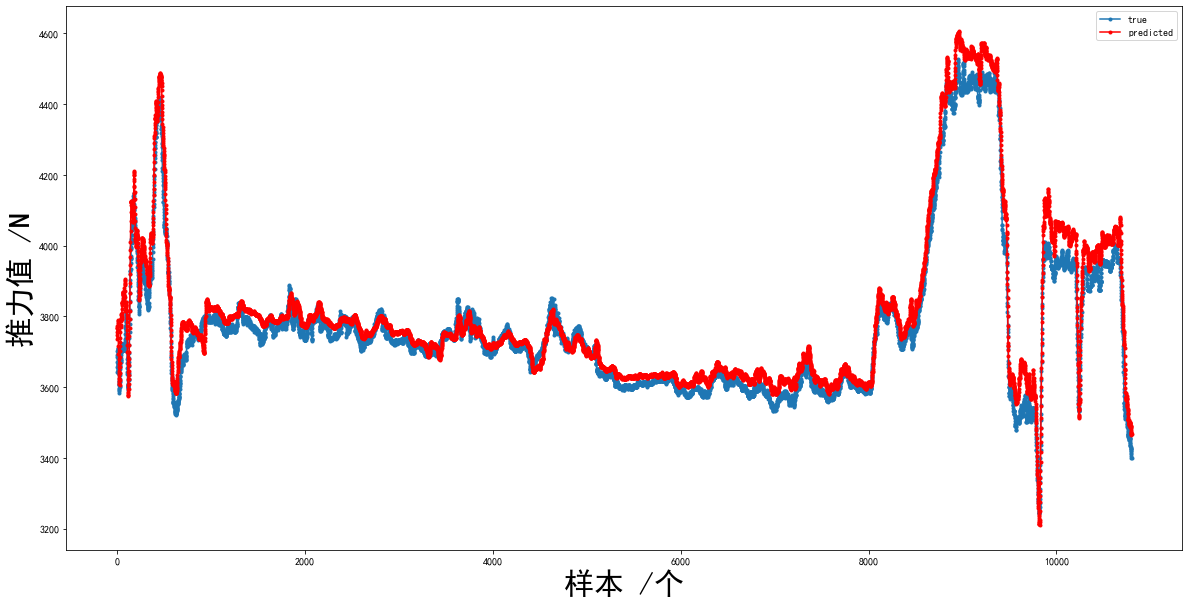

In [32]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 